Class Distribution in Original Data:
1    357
0    212
Name: count, dtype: int64

Class Distribution in Training Set (After Normalization):
1    286
0    169
Name: count, dtype: int64

Class Distribution in Testing Set (After Normalization):
1    71
0    43
Name: count, dtype: int64


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

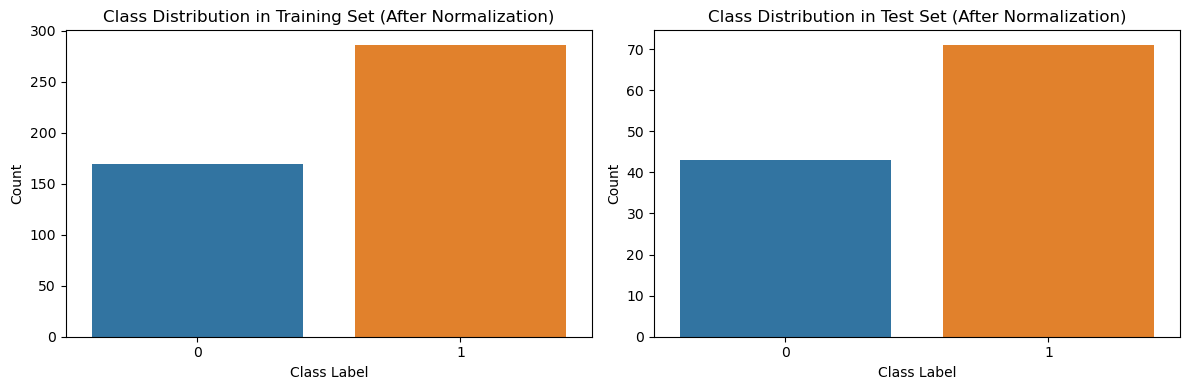

In [11]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, homogeneity_score, confusion_matrix, accuracy_score, adjusted_mutual_info_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
from sklearn.decomposition import FastICA
from sklearn.tree import DecisionTreeClassifier

# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Print class distribution before normalization
print("Class Distribution in Original Data:")
print(pd.Series(y).value_counts())

# Handling missing NaN values (replacing with mean)
X = np.nan_to_num(X)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing the data between 0 and 1
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Print class distribution after normalization
print("\nClass Distribution in Training Set (After Normalization):")
print(pd.Series(y_train).value_counts())

print("\nClass Distribution in Testing Set (After Normalization):")
print(pd.Series(y_test).value_counts())

# 4. Visualize class distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set (After Normalization)")
plt.xlabel("Class Label")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title("Class Distribution in Test Set (After Normalization)")
plt.xlabel("Class Label")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

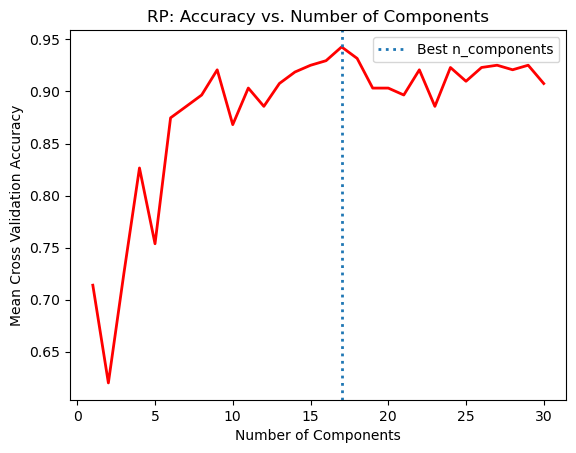

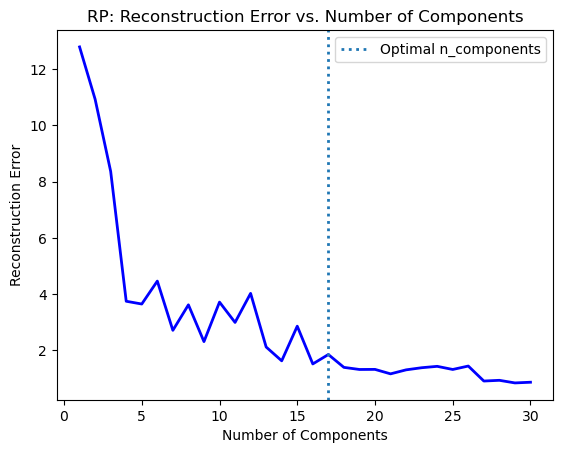

Reconstruction error with the chosen number of components (17): 1.8544475076104028


In [12]:
from sklearn import random_projection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Assuming you've already loaded and split your data as X_train, X_test, y_train, y_test

# Set up the Random Projection transformer and the Decision Tree classifier
decisiontree = DecisionTreeClassifier(criterion='gini', max_depth=15, min_samples_split=5)
rp = random_projection.GaussianRandomProjection()

# Create a pipeline that first applies RP and then fits a Decision Tree
pipe = Pipeline(steps=[('rp', rp), ('decisionTree', decisiontree)])

# Perform a grid search to find the best number of components for RP
n_components_range = range(1, X_train.shape[1]+1)
gridSearch = GridSearchCV(pipe, dict(rp__n_components=n_components_range), cv=3)
gridSearch.fit(X_train, y_train)
results = gridSearch.cv_results_

# Plot the mean cross-validation accuracy as a function of the number of components
plt.figure()
plt.plot(n_components_range, results['mean_test_score'], 'r-', linewidth=2)
plt.axvline(gridSearch.best_estimator_.named_steps['rp'].n_components, linestyle=':', label='Best n_components', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Mean Cross Validation Accuracy')
plt.title('RP: Accuracy vs. Number of Components')
plt.legend(loc='best')
plt.show()

# Apply the optimal number of components for RP to the training and testing sets
optimal_rp = gridSearch.best_estimator_.named_steps['rp']
X_train_rp = optimal_rp.transform(X_train)
X_test_rp = optimal_rp.transform(X_test)

# Function to calculate reconstruction error
def reconstruction_error(rp, X_original, X_transformed):
    X_projected = X_transformed.dot(rp.components_) + np.mean(X_original, axis=0)
    return np.mean(np.square(X_original - X_projected))

# Calculate reconstruction errors for each number of components
reconstruction_errors = []
for comp in n_components_range:
    rp = random_projection.GaussianRandomProjection(n_components=comp)
    X_transformed = rp.fit_transform(X_train)
    error = reconstruction_error(rp, X_train, X_transformed)
    reconstruction_errors.append(error)
    if comp == optimal_rp.n_components:
        chosen_error = error

# Plot the reconstruction error
plt.figure()
plt.plot(n_components_range, reconstruction_errors, 'b-', linewidth=2)
plt.axvline(optimal_rp.n_components, linestyle=':', label='Optimal n_components', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('RP: Reconstruction Error vs. Number of Components')
plt.legend(loc='best')
plt.show()

print(f"Reconstruction error with the chosen number of components ({optimal_rp.n_components}): {chosen_error}")


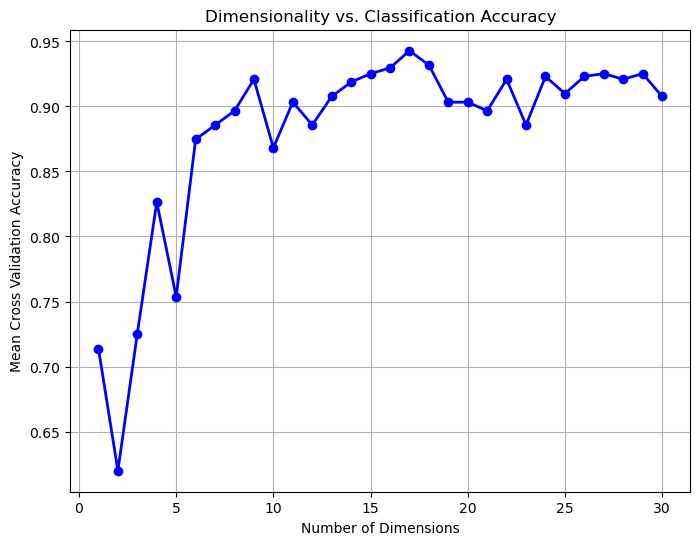

In [13]:
# Use the previous grid search results to plot dimensionality vs. accuracy
plt.figure(figsize=(8, 6))
plt.plot(n_components_range, results['mean_test_score'], 'o-', linewidth=2, color='blue')
plt.title('Dimensionality vs. Classification Accuracy')
plt.xlabel('Number of Dimensions')
plt.ylabel('Mean Cross Validation Accuracy')
plt.grid(True)
plt.show()


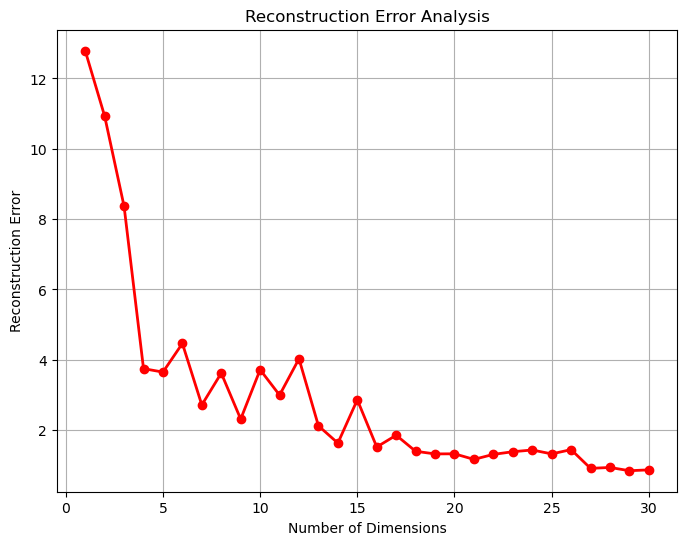

In [14]:
# Plot the reconstruction error that you calculated earlier
plt.figure(figsize=(8, 6))
plt.plot(n_components_range, reconstruction_errors, 'o-', linewidth=2, color='red')
plt.title('Reconstruction Error Analysis')
plt.xlabel('Number of Dimensions')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

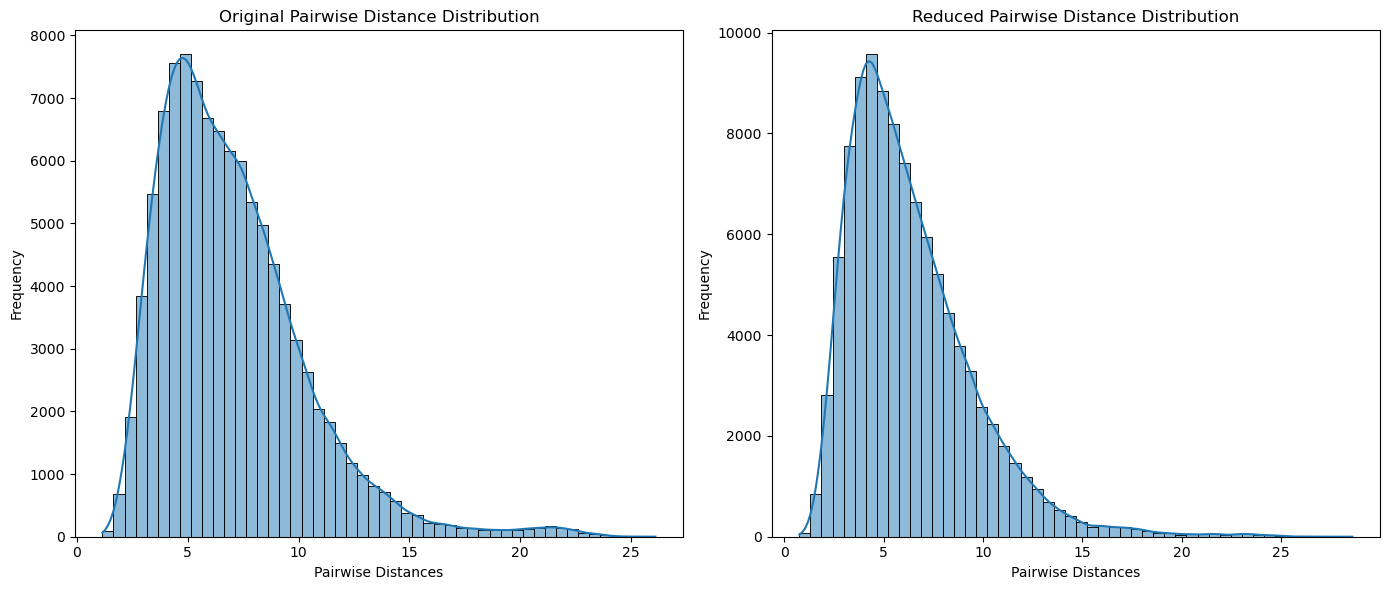

In [15]:
from scipy.spatial.distance import pdist, squareform

# Compute pairwise distances for the original and reduced datasets
original_pairwise_dist = pdist(X_train, 'euclidean')
reduced_pairwise_dist = pdist(X_train_rp, 'euclidean')

# Plot the distributions of the pairwise distances
plt.figure(figsize=(14, 6))

# Original
plt.subplot(1, 2, 1)
sns.histplot(original_pairwise_dist, bins=50, kde=True)
plt.title('Original Pairwise Distance Distribution')
plt.xlabel('Pairwise Distances')
plt.ylabel('Frequency')

# Reduced
plt.subplot(1, 2, 2)
sns.histplot(reduced_pairwise_dist, bins=50, kde=True)
plt.title('Reduced Pairwise Distance Distribution')
plt.xlabel('Pairwise Distances')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [8]:
#EM

Silhouette Score for 2 clusters: 0.27672205615932954
Silhouette Score for 3 clusters: 0.25717663859047163
Silhouette Score for 4 clusters: 0.2440206527626305
Silhouette Score for 5 clusters: 0.24179526265325907
Silhouette Score for 6 clusters: 0.1603413520628186
Silhouette Score for 7 clusters: 0.1213053100012562
Silhouette Score for 8 clusters: 0.13297281838347377
Silhouette Score for 9 clusters: 0.11911004721458969
Silhouette Score for 10 clusters: 0.147709874278963


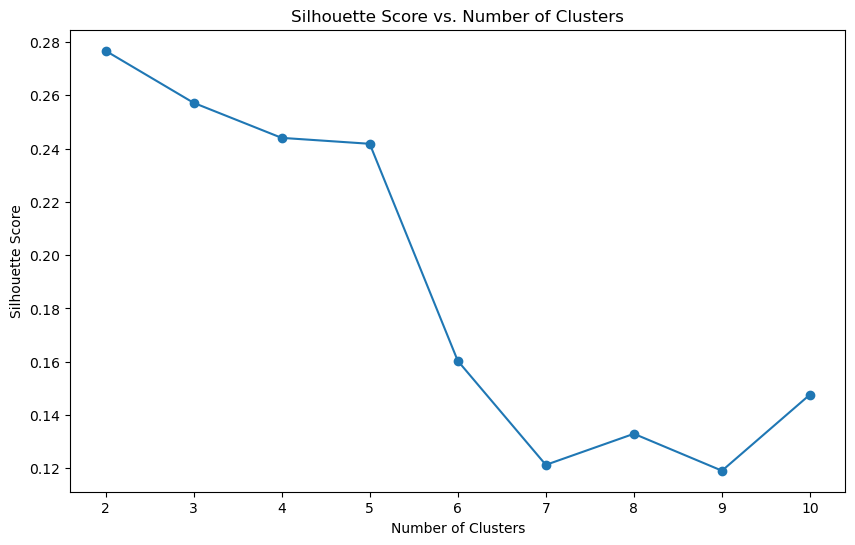

The optimal number of clusters is: 2


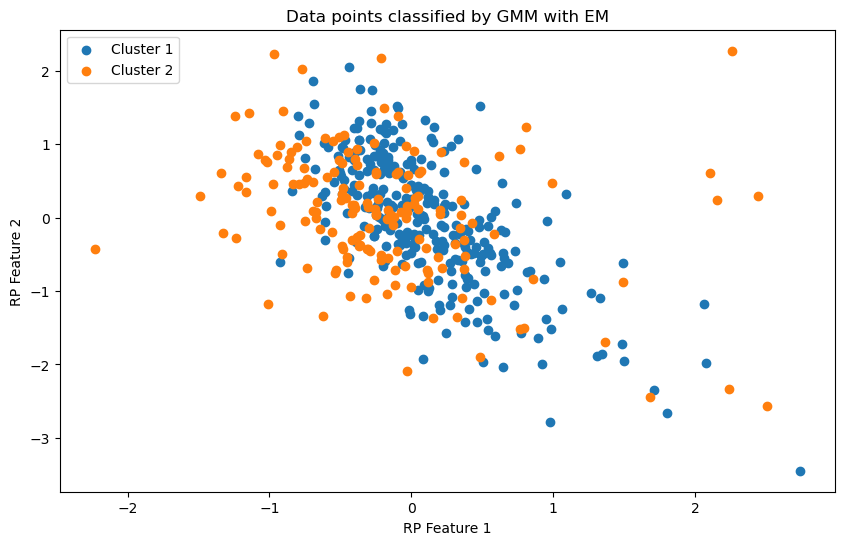

In [9]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Function to calculate silhouette score
def calculate_silhouette(X, cluster_range):
    silhouette_scores = []
    for n_clusters in cluster_range:
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        labels = gmm.fit_predict(X)
        silhouette_avg = silhouette_score(X, labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")
    return silhouette_scores

# Determine the optimal number of clusters using silhouette score
cluster_range = range(2, 11)  # Let's try from 2 to 10 clusters
silhouette_scores = calculate_silhouette(X_train_rp, cluster_range)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xticks(cluster_range)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

# Choose the optimal number of clusters as the one with the highest silhouette score
optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 because range starts at 2
print(f"The optimal number of clusters is: {optimal_clusters}")

# Fit the Gaussian Mixture Model with the optimal number of clusters
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gmm.fit(X_train_rp)

# Predict the cluster for each data point
labels = gmm.predict(X_train_rp)

# Plot the clusters
plt.figure(figsize=(10, 6))
for i in range(optimal_clusters):
    plt.scatter(X_train_rp[labels == i, 0], X_train_rp[labels == i, 1], label=f'Cluster {i+1}')
plt.title('Data points classified by GMM with EM')
plt.xlabel('RP Feature 1')
plt.ylabel('RP Feature 2')
plt.legend()
plt.show()


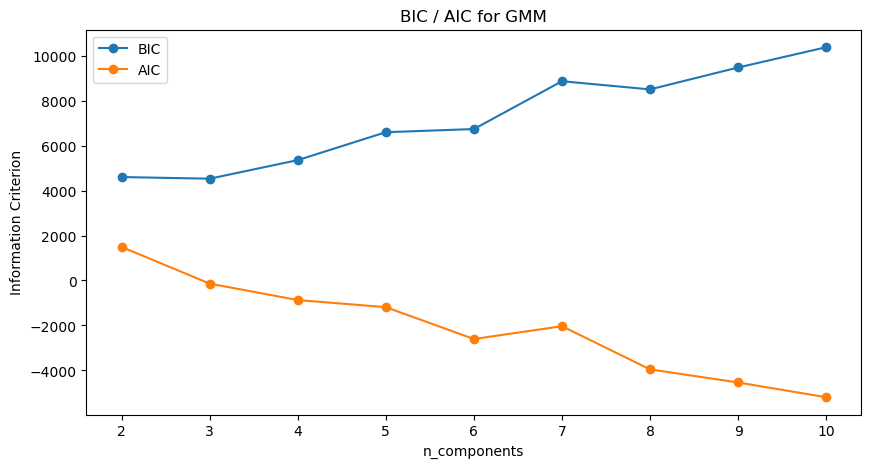

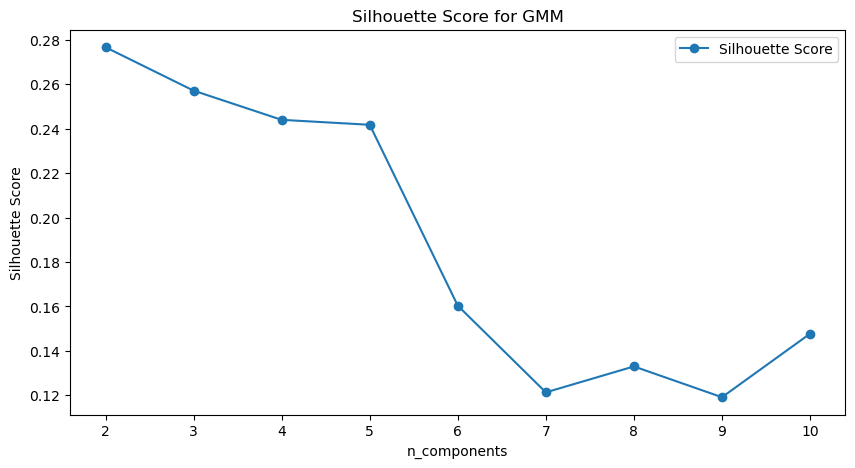

Optimal number of components based on BIC: 3
Optimal number of components based on AIC: 10
Optimal number of components based on silhouette score: 2


In [10]:
# Compute BIC and AIC for a range of number of components
n_components_range = range(2, 11)  # Typically, you would choose a range based on domain knowledge or experimentation
bics = []
aics = []

for n_components in n_components_range:
    # Fit a Gaussian mixture with EM
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train_rp)
    bics.append(gmm.bic(X_train_rp))
    aics.append(gmm.aic(X_train_rp))

# Plot the BIC scores
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bics, label='BIC', marker='o')
plt.plot(n_components_range, aics, label='AIC', marker='o')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Information Criterion')
plt.title('BIC / AIC for GMM')
plt.show()

# Calculate the silhouette scores for the same range of n_components
silhouette_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train_rp)
    labels = gmm.predict(X_train_rp)
    silhouette_avg = silhouette_score(X_train_rp, labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, silhouette_scores, label='Silhouette Score', marker='o')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for GMM')
plt.show()

# Find the optimal number of components based on BIC, AIC and silhouette score
optimal_n_components_bic = n_components_range[np.argmin(bics)]
optimal_n_components_aic = n_components_range[np.argmin(aics)]
optimal_n_components_silhouette = n_components_range[np.argmax(silhouette_scores)]

print(f"Optimal number of components based on BIC: {optimal_n_components_bic}")
print(f"Optimal number of components based on AIC: {optimal_n_components_aic}")
print(f"Optimal number of components based on silhouette score: {optimal_n_components_silhouette}")


In [16]:
#K-Means

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

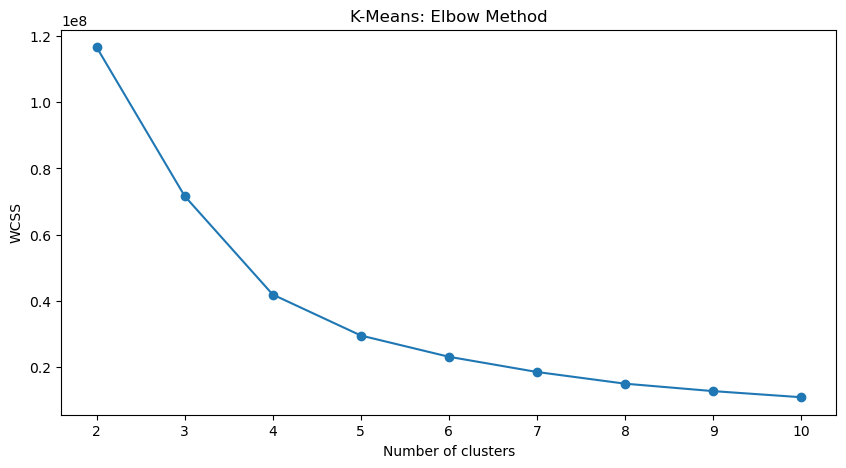

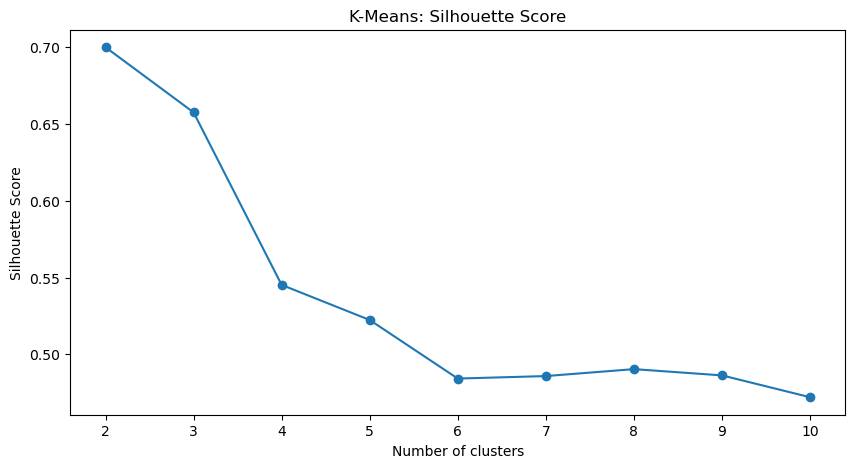

Optimal number of clusters based on silhouette score: 2


In [27]:
# Find the optimal number of clusters for K-Means using the elbow method and silhouette score
from sklearn import random_projection

# Assuming you've already determined that the optimal number of components is 22
optimal_n_components = 22
rp = random_projection.GaussianRandomProjection(n_components=optimal_n_components)

# Apply RP transformation to the entire dataset
X_train_rp = rp.fit_transform(X)

# Assuming you have the variable `X_train_rp` which is your data after applying RP

# Range of clusters to try
clusters_range = range(2, 11)

# Variables to hold the results
wcss = []
silhouette_scores_km = []

for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train_rp)
    wcss.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_train_rp, labels)
    silhouette_scores_km.append(silhouette_avg)

# Plot WCSS / SSE
plt.figure(figsize=(10, 5))
plt.plot(clusters_range, wcss, marker='o')
plt.title('K-Means: Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(clusters_range, silhouette_scores_km, marker='o')
plt.title('K-Means: Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Find the optimal number of clusters based on silhouette score
optimal_n_clusters_silhouette = clusters_range[np.argmax(silhouette_scores_km)]
print(f"Optimal number of clusters based on silhouette score: {optimal_n_clusters_silhouette}")

# If you want to use the elbow method to determine the optimal number of clusters,
# you can visually inspect the plot or use a more algorithmic approach like the "knee" method.
# However, this part is usually more subjective.

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


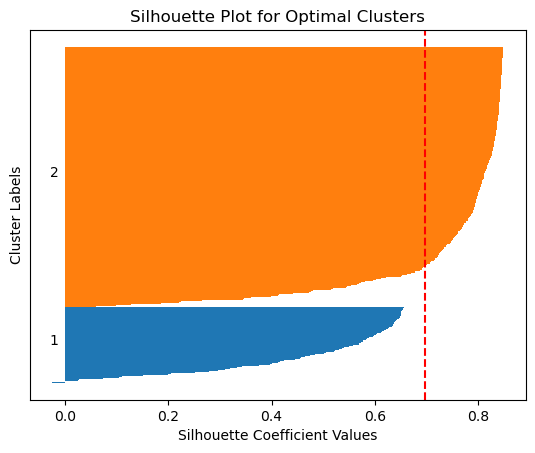

In [28]:
from sklearn.metrics import silhouette_samples
from sklearn import random_projection

# Assuming you've already determined that the optimal number of components is 22
optimal_n_components = 22
rp = random_projection.GaussianRandomProjection(n_components=optimal_n_components)

# Apply RP transformation to the entire dataset
X_train_rp = rp.fit_transform(X)

from sklearn.cluster import KMeans

# Now perform KMeans clustering on the RP-transformed data
kmeans = KMeans(n_clusters=2, random_state=42)  # Assuming 2 is the optimal number of clusters
kmeans.fit(X_train_rp)
labels = kmeans.labels_


# Silhouette analysis on optimal clusters
silhouette_vals = silhouette_samples(X_train_rp, labels)

# Silhouette plot
y_ticks = []
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(labels)):
    cluster_silhouette_vals = silhouette_vals[labels == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    plt.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
    y_lower += len(cluster_silhouette_vals)

# The vertical line for average silhouette score of all the values
avg_score = np.mean(silhouette_vals)
plt.axvline(avg_score, color="red", linestyle="--")

plt.yticks([])
plt.title('Silhouette Plot for Optimal Clusters')
plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster Labels')
plt.show()

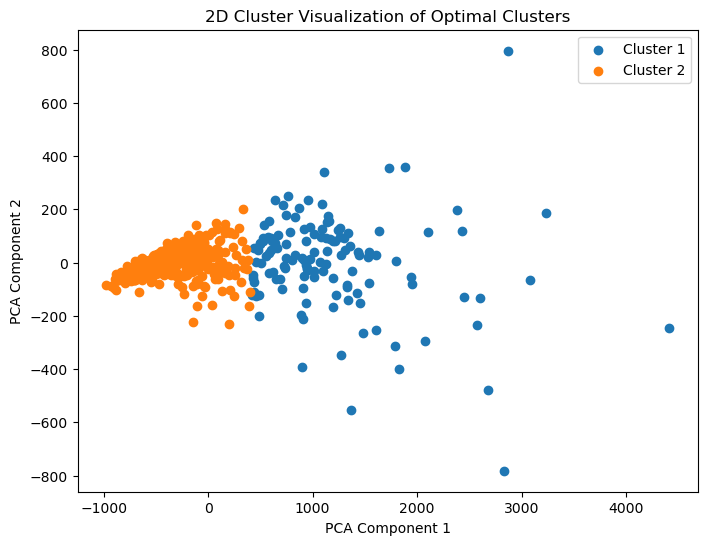

In [29]:
from sklearn.decomposition import PCA

# Further reduce the dimensionality to 2D for visualization purposes
pca = PCA(n_components=2)
X_train_rp_2d = pca.fit_transform(X_train_rp)

plt.figure(figsize=(8, 6))
for i in range(2):
    plt.scatter(X_train_rp_2d[labels == i, 0], X_train_rp_2d[labels == i, 1], label=f'Cluster {i+1}')
plt.title('2D Cluster Visualization of Optimal Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


In [30]:
print(f'Silhouette Score for 2 clusters: {silhouette_score(X_train_rp, labels)}')


Silhouette Score for 2 clusters: 0.6973875598302223


In [31]:
from sklearn.metrics import calinski_harabasz_score

print(f'Calinski-Harabasz Index for 2 clusters: {calinski_harabasz_score(X_train_rp, labels)}')


Calinski-Harabasz Index for 2 clusters: 1297.03441814328


In [32]:
from sklearn.metrics import davies_bouldin_score

print(f'Davies-Bouldin Index for 2 clusters: {davies_bouldin_score(X_train_rp, labels)}')


Davies-Bouldin Index for 2 clusters: 0.5025080339779022
